In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr


Treino: (16, 66) | Teste (3): (16, 66)

📈 Avaliação para o ano 3:
R² = 0.732
RMSE = 2.32

🏀 Ranking previsto vs real:
     year confID tmID  won   pred_won  rank  pred_rank
4       3     EA  CHA   18  19.091195     2        1.0
78      3     EA  NYL   18  19.052442     1        2.0
134     3     EA  WAS   17  15.878821     3        3.0
45      3     EA  IND   16  14.221941     4        4.0
88      3     EA  ORL   16  14.142818     5        5.0
65      3     EA  MIA   15  13.804083     6        6.0
15      3     EA  CLE   10  13.166605     7        7.0
26      3     EA  DET    9  10.627543     8        8.0
55      3     WE  LAS   25  24.965768     1        1.0
36      3     WE  HOU   24  23.445020     2        2.0
121     3     WE  SEA   17  19.061568     4        3.0
131     3     WE  UTA   20  19.059419     3        4.0
101     3     WE  POR   16  13.307277     5        5.0
68      3     WE  MIN   10  11.375064     8        6.0
104     3     WE  SAC   14   9.366545     6        7.0
91

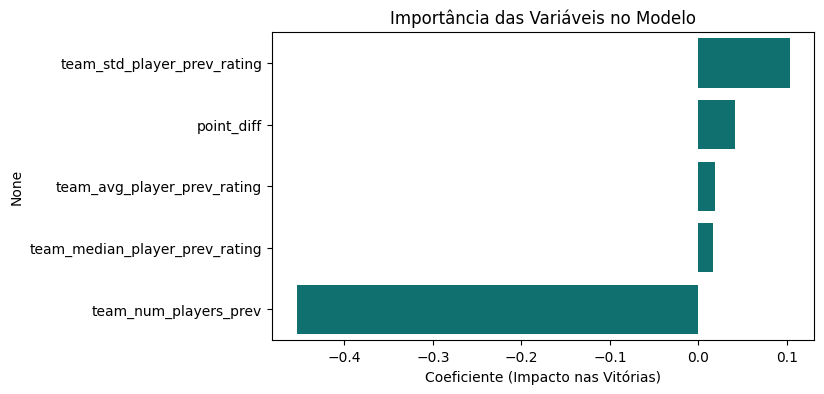

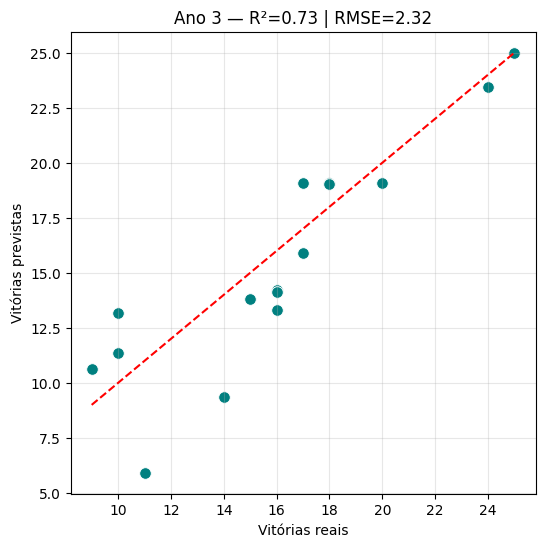

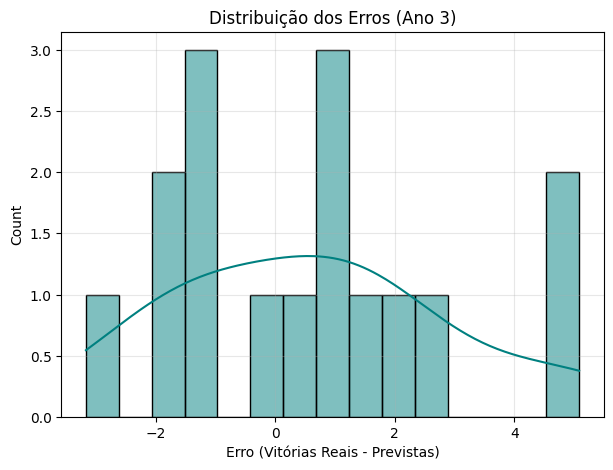


Média dos erros (≈0 esperado): 0.5947647300701422

✅ Resultados guardados em: data_models/predictions_model1.csv


In [34]:
# ===============================================================
# 🏀 Modelo 1 — Previsão de Vitórias a partir da Força e Estatísticas da Época Anterior
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import os

# 1️⃣ Ler os dados principais
teams = pd.read_csv("data/teams.csv")
team_prev_ratings = pd.read_csv("data_models/team_prev_ratings.csv")

# 2️⃣ Juntar a força da equipa (ano anterior) ao dataset de equipas
teams_full = pd.merge(teams, team_prev_ratings, on=["year", "tmID"], how="left")

# 3️⃣ Adicionar feature auxiliar — diferença de pontos
teams_full["point_diff"] = teams_full["o_pts"] - teams_full["d_pts"]

# 4️⃣ Escolher o ano a prever
target_year = 3  # anos so acima de 3

train_data = teams_full[teams_full["year"] == target_year - 1]
test_data  = teams_full[teams_full["year"] == target_year]

print(f"Treino: {train_data.shape} | Teste ({target_year}): {test_data.shape}")

# 5️⃣ Selecionar features (todas do FE + performance anterior)
features = [
    "team_avg_player_prev_rating",
    "team_median_player_prev_rating",
    "team_std_player_prev_rating",
    "team_num_players_prev",
    "point_diff"
]

train_data = train_data.dropna(subset=features + ["won"])
test_data  = test_data.dropna(subset=features + ["won"])

X_train = train_data[features]
y_train = train_data["won"]
X_test  = test_data[features]
y_test  = test_data["won"]

# 6️⃣ Treinar modelo com regularização leve
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# 7️⃣ Fazer previsões
test_data["pred_won"] = model.predict(X_test)

# 8️⃣ Avaliar performance
r2 = r2_score(y_test, test_data["pred_won"])
rmse = np.sqrt(mean_squared_error(y_test, test_data["pred_won"]))

print(f"\n📈 Avaliação para o ano {target_year}:")
print(f"R² = {r2:.3f}")
print(f"RMSE = {rmse:.2f}")

# 9️⃣ Ranking previsto por conferência
test_data["pred_rank"] = test_data.groupby("confID")["pred_won"].rank(ascending=False)

# 🔟 Mostrar ranking previsto vs real
print("\n🏀 Ranking previsto vs real:")
print(
    test_data[["year", "confID", "tmID", "won", "pred_won", "rank", "pred_rank"]]
    .sort_values(["confID", "pred_rank"])
    .head(20)
)

# 11️⃣ Importância das variáveis
coef = pd.Series(model.coef_, index=features).sort_values(ascending=False)
plt.figure(figsize=(7,4))
sns.barplot(x=coef.values, y=coef.index, color="teal")
plt.title("Importância das Variáveis no Modelo")
plt.xlabel("Coeficiente (Impacto nas Vitórias)")
plt.show()

# 12️⃣ Visualização — Vitórias Reais vs Previstas
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=test_data["pred_won"], color="teal", s=70)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Vitórias reais")
plt.ylabel("Vitórias previstas")
plt.title(f"Ano {target_year} — R²={r2:.2f} | RMSE={rmse:.2f}")
plt.grid(alpha=0.3)
plt.show()

# 13️⃣ Análise dos erros
test_data["residual"] = y_test - test_data["pred_won"]
plt.figure(figsize=(7,5))
sns.histplot(test_data["residual"], bins=15, kde=True, color="teal")
plt.title(f"Distribuição dos Erros (Ano {target_year})")
plt.xlabel("Erro (Vitórias Reais - Previstas)")
plt.grid(alpha=0.3)
plt.show()

print("\nMédia dos erros (≈0 esperado):", test_data["residual"].mean())

# 14️⃣ Guardar previsões
os.makedirs("data_models", exist_ok=True)
test_data.to_csv("data_models/predictions_model1.csv", index=False)
print("\n✅ Resultados guardados em: data_models/predictions_model1.csv")


In [25]:
# ===============================================================
# Alínea (a) — Previsão do Ranking da Regular Season - Regressão Linear
# ===============================================================

#Prever o número de vitórias (“won”) que cada equipa terá numa época,
#com base em estatísticas como pontos marcados, sofridos, eficiências e rebonces
#Depois disso, ordenar as equipas pelo número previsto de vitórias = ranking previsto

# ---------------------------------------------------------------
# Selecionar variáveis explicativas e alvo
# ---------------------------------------------------------------
# Objetivo: prever o número de vitórias ("won") com base em estatísticas da equipa
features = ["o_pts", "d_pts", "point_diff", "off_efficiency", "def_efficiency", "rebalance"]
X = teams_model[features]
y = teams_model["won"]

# ---------------------------------------------------------------
# Escalar as variáveis (boa prática para regressão linear)
# ---------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------------------------------
# Separar dados em treino e teste
# ---------------------------------------------------------------
#train_data = teams_model[teams_model["year"] < 2019] -> IMPORTANTE PARA TESTAR TREINAR ANOS ANTERIORES E TESTAR ANO QUE QUERO
#test_data = teams_model[teams_model["year"] == 2019]

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# ---------------------------------------------------------------
# Treinar modelo de Regressão Linear
# ---------------------------------------------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# ---------------------------------------------------------------
# Fazer previsões no conjunto de teste
# ---------------------------------------------------------------
y_pred = model.predict(X_test)

# ---------------------------------------------------------------
# Avaliar performance do modelo
# ---------------------------------------------------------------
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")

# ---------------------------------------------------------------
# Visualizar: Vitórias Reais vs Previstas
# ---------------------------------------------------------------
plt.figure(figsize=(7,7))
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"}, scatter_kws={"alpha":0.7, "color":"teal"})
plt.xlabel("Vitórias Reais")
plt.ylabel("Vitórias Previstas")
plt.title(f"Regressão Linear — Vitórias Reais vs Previstas (R² = {r2:.2f})")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# ---------------------------------------------------------------
# Importância das variáveis (coeficientes da regressão)
# ---------------------------------------------------------------
importance = pd.Series(model.coef_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=importance.values, y=importance.index, color='teal')
plt.title("Importância das Variáveis (Coeficientes da Regressão)")
plt.xlabel("Peso no Modelo")
plt.ylabel("Variável")
plt.show()

# ---------------------------------------------------------------
# Análise dos erros (residuais)
# ---------------------------------------------------------------
residuals = y_test - y_pred
plt.figure(figsize=(7,5))
sns.histplot(residuals, bins=20, kde=True, color="teal")
plt.title("Distribuição dos Erros (Residuais)")
plt.xlabel("Erro (Vitórias Reais - Previstas)")
plt.show()

# ---------------------------------------------------------------
# Previsão completa e ranking por temporada
# ---------------------------------------------------------------
# Prever vitórias para todos os registos
teams_model["pred_won"] = model.predict(scaler.transform(X))
teams_model["pred_rank"] = teams_model.groupby("year")["pred_won"].rank(ascending=False)

# Mostrar os 10 primeiros resultados
print("\n🏅 Ranking previsto (Regressão Linear - 10 primeiros resultados):")
print(teams_model[["year", "tmID", "won", "rank", "pred_won", "pred_rank"]].head(10))

# ===============================================================
# Avaliação de Performance do Modelo
# ===============================================================

# --- Accuracy (dentro de ±1 vitória) ---
tolerance = 1
accuracy_within_1 = np.mean(np.abs(y_test - y_pred) <= tolerance)
print(f"\nAccuracy (±1 vitória): {accuracy_within_1*100:.1f}%")

# --- Accuracy de ranking (dentro de ±1 posição) ---
rank_accuracy = np.mean(np.abs(teams_model["rank"] - teams_model["pred_rank"]) <= 1)
print(f"Accuracy de ranking (±1 posição): {rank_accuracy*100:.1f}%")

# --- Erro médio absoluto (MAE) ---
mae = mean_absolute_error(y_test, y_pred)
print(f"Erro médio absoluto (MAE): {mae:.2f}")

# --- Raiz do erro quadrático médio (RMSE) ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Raiz do erro quadrático médio (RMSE): {rmse:.2f}")

# --- Correlação de ranking (Spearman) ---
rank_corr, _ = spearmanr(teams_model["rank"], teams_model["pred_rank"])
print(f"Correlação de ranking (Spearman): {rank_corr:.3f}")


# ---------------------------------------------------------------
# Visualizar ranking previsto vs real
# ---------------------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(data=teams_model, x="won", y="pred_won", hue="year", palette="viridis", alpha=0.7)
plt.plot([teams_model["won"].min(), teams_model["won"].max()],
         [teams_model["won"].min(), teams_model["won"].max()],
         "r--", label="Real = Previsto")
plt.xlabel("Vitórias Reais")
plt.ylabel("Vitórias Previstas")
plt.title("Comparação entre Vitórias Reais e Previstas (Todas as Temporadas)")
plt.legend()
plt.show()


NameError: name 'teams_model' is not defined

=== Random Forest Regressor ===
R²: 0.847, RMSE: 1.94



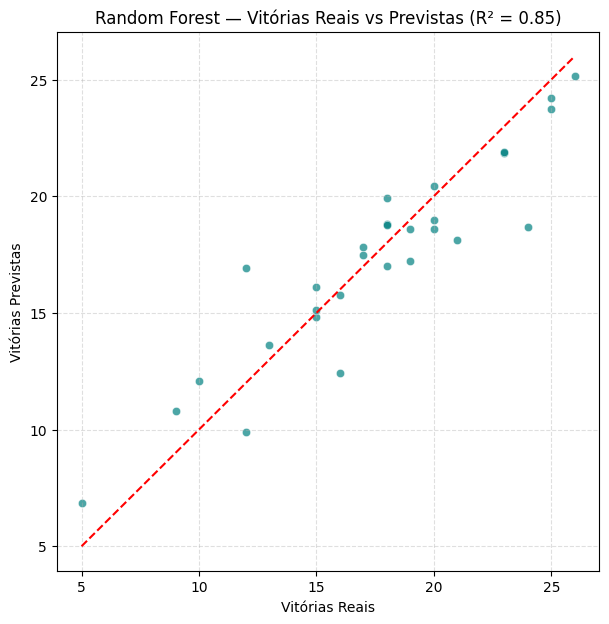

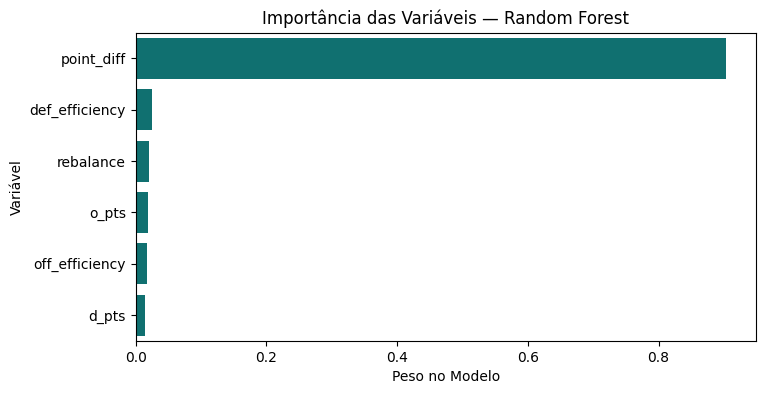

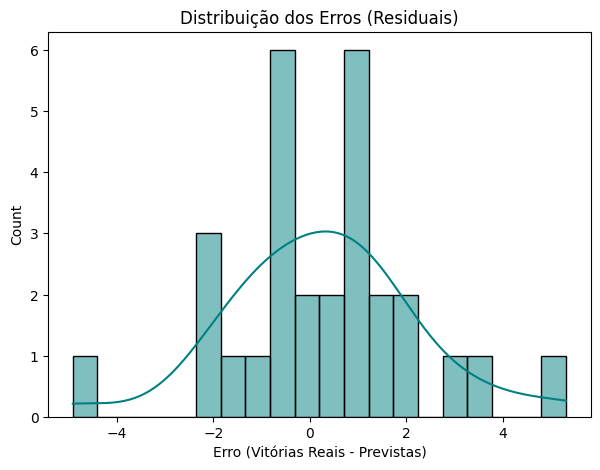


🏅 Ranking previsto (Random Forest - 10 primeiros resultados):
   year tmID  won  rank  pred_won_rf  pred_rank_rf
0     9  ATL    4     7        5.845          14.0
1    10  ATL   18     2       18.070           5.0
2     1  CHA    8     8        8.015          15.0
3     2  CHA   18     4       18.295           6.0
4     3  CHA   18     2       19.925           3.0
5     4  CHA   18     2       17.620           6.0
6     5  CHA   16     5       14.795          11.0
7     6  CHA    6     6        7.135          13.0
8     7  CHA   11     6       11.820          11.0
9     7  CHI    5     7        6.870          14.0

Accuracy (±1 vitória): 44.8%
Accuracy de ranking (±1 posição): 29.6%
Erro médio absoluto (MAE): 1.48
Raiz do erro quadrático médio (RMSE): 1.94
Correlação de ranking (Spearman): 0.847


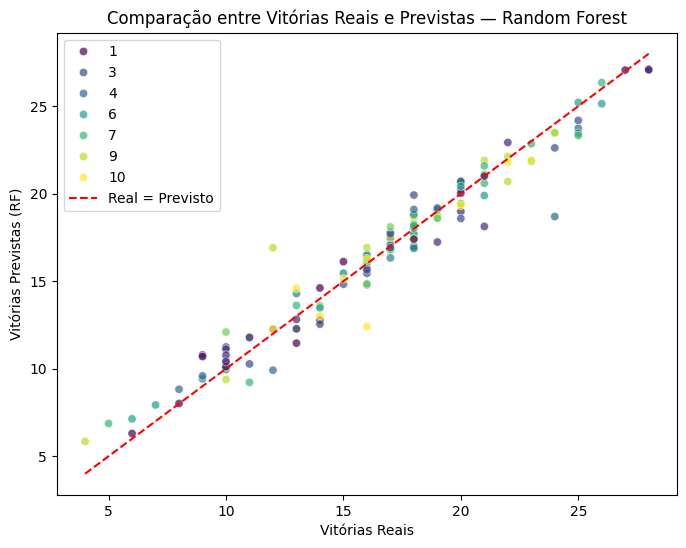

In [ ]:
# ===============================================================
# Alínea (a) — Previsão do Ranking da Regular Season - Random Forest
# ===============================================================

# ---------------------------------------------------------------
# Selecionar variáveis explicativas e alvo
# ---------------------------------------------------------------
features = ["o_pts", "d_pts", "point_diff", "off_efficiency", "def_efficiency", "rebalance"]
X = teams_model[features]
y = teams_model["won"]

# ---------------------------------------------------------------
# Separar dados em treino e teste (sem escalar)
# ---------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------------------------------------------
# Treinar modelo de Random Forest
# ---------------------------------------------------------------
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# ---------------------------------------------------------------
# Fazer previsões no conjunto de teste
# ---------------------------------------------------------------
y_pred = model.predict(X_test)

# ---------------------------------------------------------------
# Avaliar performance do modelo
# ---------------------------------------------------------------
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("=== Random Forest Regressor ===")
print(f"R²: {r2:.3f}, RMSE: {rmse:.2f}\n")

# ---------------------------------------------------------------
# Visualizar: Vitórias Reais vs Previstas
# ---------------------------------------------------------------
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="teal")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Vitórias Reais")
plt.ylabel("Vitórias Previstas")
plt.title(f"Random Forest — Vitórias Reais vs Previstas (R² = {r2:.2f})")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# ---------------------------------------------------------------
# Importância das variáveis (feature importance)
# ---------------------------------------------------------------
importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=importance.values, y=importance.index, color='teal')
plt.title("Importância das Variáveis — Random Forest")
plt.xlabel("Peso no Modelo")
plt.ylabel("Variável")
plt.show()

# ---------------------------------------------------------------
# Análise dos erros (residuais)
# ---------------------------------------------------------------
residuals = y_test - y_pred
plt.figure(figsize=(7,5))
sns.histplot(residuals, bins=20, kde=True, color="teal")
plt.title("Distribuição dos Erros (Residuais)")
plt.xlabel("Erro (Vitórias Reais - Previstas)")
plt.show()

# ---------------------------------------------------------------
# Previsão completa e ranking por temporada
# ---------------------------------------------------------------
teams_model["pred_won_rf"] = model.predict(X)
teams_model["pred_rank_rf"] = teams_model.groupby("year")["pred_won_rf"].rank(ascending=False)

# Mostrar os 10 primeiros resultados
print("\n🏅 Ranking previsto (Random Forest - 10 primeiros resultados):")
print(teams_model[["year", "tmID", "won", "rank", "pred_won_rf", "pred_rank_rf"]].head(10))

# ===============================================================
# 📊 Avaliação de Performance do Modelo
# ===============================================================

# --- Accuracy (dentro de ±1 vitória) ---
tolerance = 1
accuracy_within_1 = np.mean(np.abs(y_test - y_pred) <= tolerance)
print(f"\nAccuracy (±1 vitória): {accuracy_within_1*100:.1f}%")

# --- Accuracy de ranking (dentro de ±1 posição) ---
rank_accuracy = np.mean(np.abs(teams_model["rank"] - teams_model["pred_rank"]) <= 1)
print(f"Accuracy de ranking (±1 posição): {rank_accuracy*100:.1f}%")

# --- Erro médio absoluto (MAE) ---
mae = mean_absolute_error(y_test, y_pred)
print(f"Erro médio absoluto (MAE): {mae:.2f}")

# --- Raiz do erro quadrático médio (RMSE) ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Raiz do erro quadrático médio (RMSE): {rmse:.2f}")

# --- Correlação de ranking (Spearman) ---
rank_corr, _ = spearmanr(teams_model["rank"], teams_model["pred_rank"])
print(f"Correlação de ranking (Spearman): {rank_corr:.3f}")


# ---------------------------------------------------------------
# Visualizar ranking previsto vs real
# ---------------------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(data=teams_model, x="won", y="pred_won_rf", hue="year", palette="viridis", alpha=0.7)
plt.plot([teams_model["won"].min(), teams_model["won"].max()],
         [teams_model["won"].min(), teams_model["won"].max()],
         "r--", label="Real = Previsto")
plt.xlabel("Vitórias Reais")
plt.ylabel("Vitórias Previstas (RF)")
plt.title("Comparação entre Vitórias Reais e Previstas — Random Forest")
plt.legend()
plt.show()
